In [2]:
import pandas as pd
import numpy as np

from shapely.geometry import LineString, Point
from common.tools import inegi_projection
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
paradas = inegi_projection(pd.read_csv("data/paradas.csv"))
travel_times = pd.read_csv("data/travel_times.csv")
travel_times = travel_times.rename(columns={"last": "origin", "current": "destination", "last_arrival": "departure"})
travel_times.departure = pd.to_datetime(travel_times.departure)
travel_times.travel_time = pd.to_timedelta(travel_times.travel_time)
travel_times["seconds"] = travel_times.travel_time.map(lambda x: x.total_seconds())

In [4]:
# Add travel distance
route = {
    "outbound": LineString(pd.read_csv("s3://datank-wawa/data/datank/ruta_bsf.csv")[["x", "y"]].values),
    "inbound": LineString(pd.read_csv("s3://datank-wawa/data/datank/ruta_sfb.csv")[["x", "y"]].values)
}
paradas["distance"] = [route[row.leg].project(Point(row.x, row.y)) for i, row in paradas.iterrows()]
travel_distance = paradas.distance - paradas.distance.shift()
travel_distance.name = "travel_distance"
travel_times["travel_distance"] = travel_times.join(travel_distance, on="origin")["travel_distance"]


In [5]:
# Some periodicity features
travel_times["year"] = travel_times.departure.dt.year
travel_times["month"] = travel_times.departure.dt.month
travel_times["day"] = travel_times.departure.dt.day
travel_times["hour"] = travel_times.departure.dt.hour
travel_times["weekend"] = travel_times.departure.map(lambda x: x.dayofweek > 4).astype(int)



In [6]:
# Google Distance Matrix estimate
gdm = pd.read_csv("s3://datank-wawa/data/google/gdm_estimates.csv")
gdm.timestamp = pd.to_datetime(gdm.timestamp)
gdm["weekend"] = (gdm.timestamp.dt.weekday >= 5).astype(int)
gdm["hour"] = gdm.timestamp.dt.hour
gdm["origin"] = cdist(gdm[["origin_lat", "origin_lon"]], paradas[["latitud", "longitud"]]).argmin(axis=1)

gdm = gdm.groupby(['weekend','origin', 'hour'])[["duration", "duration_in_traffic"]].mean().reset_index()

travel_times = travel_times.merge(gdm[["origin", "weekend", "hour", "duration_in_traffic"]], on=["origin", "weekend","hour"], how="left")

In [7]:
# Weather
weather_df = pd.read_csv("s3://datank-wawa/data/datank/weather.csv")
weather_df.ts = pd.to_datetime(weather_df.ts)
weather = weather_df.groupby("ts")["description"].apply(lambda x: ', '.join(x)).reset_index()
weather["year"] = weather.ts.dt.year
weather["month"] = weather.ts.dt.month
weather["day"] = weather.ts.dt.day
weather["hour"] = weather.ts.dt.hour
def rain_type(desc):
    if "rain" not in desc:
        return 'none'
    elif "light" in desc:
        return 'light'
    elif "heavy" in desc:
        return "heavy"
    else:
        return "moderate"
weather["rain_type"] = weather.description.map(rain_type)

travel_times = travel_times.merge(weather[["year", "month", "day", "hour", "rain_type"]], on=["year", "month", "day", "hour"], how="left")
travel_times.rain_type = travel_times.rain_type.fillna('unknown')
travel_times["raining"] = travel_times.rain_type != "none"

In [8]:
features = ["travel_distance", "duration_in_traffic", "weekend", "hour", "raining"]
response = "seconds"

# Split into train and test sets randomly
np.random.seed(42)
is_test = np.random.rand(len(travel_times)) < 0.2
X_train = travel_times[features][~is_test]
y_train = travel_times[response][~is_test]
X_test = travel_times[features][is_test]
y_test = travel_times[response][is_test]

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
def model_results(test, pred, scatter_kwargs={}, hist_kwargs={}):
    x0 = y0 = pred.min() 
    x1 = y1 = pred.max()
    plt.figure(figsize=(10, 7))
    #Scatter
    plt.scatter(test, pred, **scatter_kwargs)
    # Draw a identity line
    plt.plot([x0, x1], [y0, y1], color="black")
    plt.title("Real vs Predicted")
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.show()
    # Look at reiduals
    plt.figure(figsize=(10, 7))
    plt.hist(test - pred, bins=30, **hist_kwargs)
    plt.title("Residual Distribution")
    plt.show()
    
    err = np.abs(test - pred)
    print(np.abs(test - pred).describe())
    result = {
        "mean": err.mean(),
        "median": err.median(),
        "str": err.std(),
        "q75": err.quantile(0.75),
        "q90": err.quantile(0.9),
        "q99": err.quantile(0.99)
    }
    return result
    
    


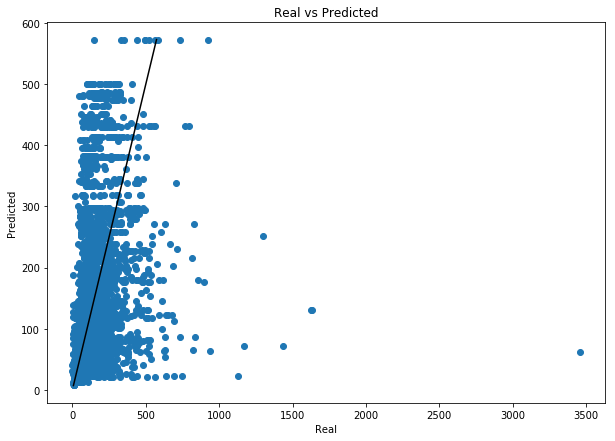

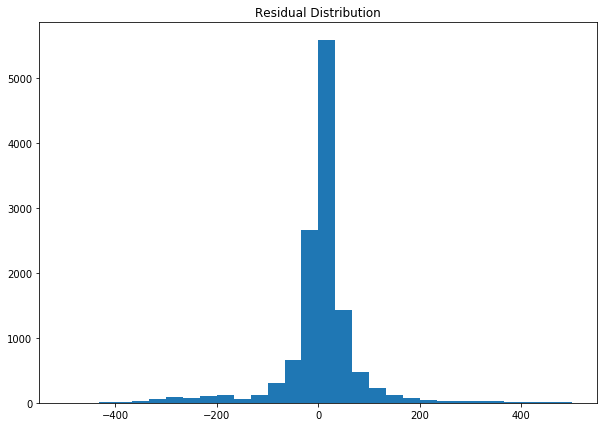

count    12412.000000
mean        44.599501
std         79.339095
min          0.000202
25%          8.570543
50%         20.083718
75%         46.087958
max       3394.135929
dtype: float64


In [10]:
# Simplest thing: use the google distance matrix directly
y_pred = X_test["duration_in_traffic"]
results = []
result = model_results(y_test, y_pred, hist_kwargs={"range": (-500, 500)})
result["model"] = "google_distance_matrix"
results.append(result)

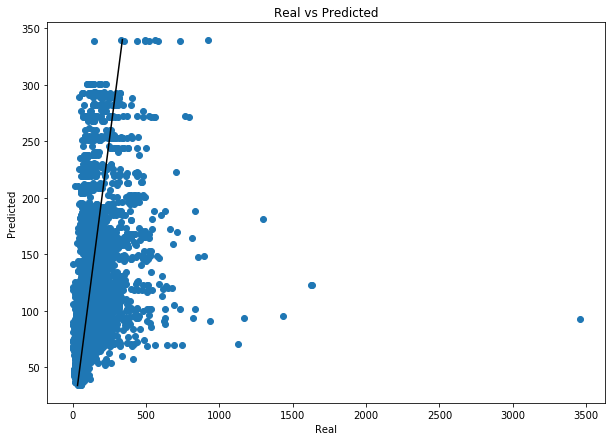

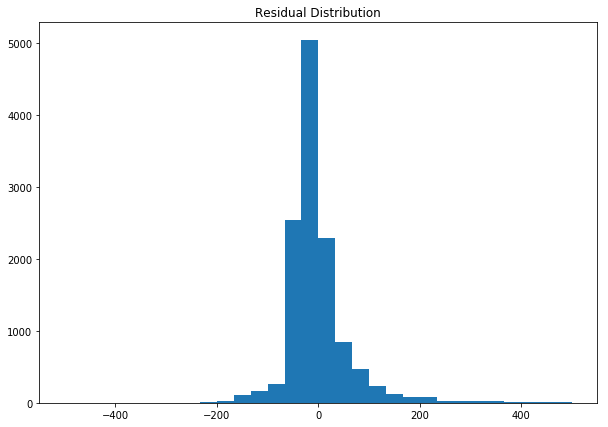

count    12412.000000
mean        41.766274
std         67.164612
min          0.001377
25%         13.889045
50%         27.586482
75%         46.171148
max       3363.294955
Name: seconds, dtype: float64


In [11]:
# Linear model
linear = LinearRegression(normalize=True)
linear.fit(X_train.values, y_train.values)
y_pred = linear.predict(X_test)
result = model_results(y_test, y_pred, hist_kwargs={"range": (-500, 500)})
result["model"] = "linear_full"
results.append(result)

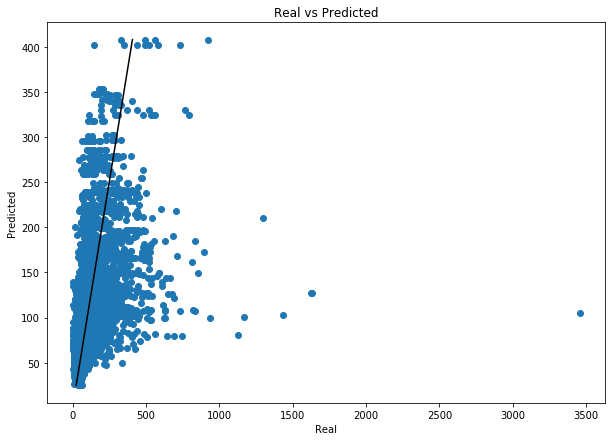

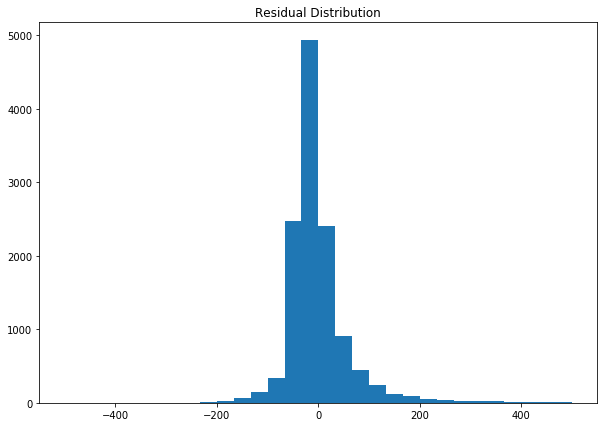

count    12412.000000
mean        41.144738
std         65.989602
min          0.002073
25%         13.442631
50%         27.016620
75%         48.152710
max       3350.723027
Name: seconds, dtype: float64


In [12]:
from sklearn.base import BaseEstimator, RegressorMixin


class HourLinearEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, hours=[0], hour_col="hour", normalize=True):        
        self.hours = hours
        self.hour_col = hour_col
        self.normalize = normalize
        
        h = [*hours, 24]
        self._start_hours = h[:-1]
        self._end_hours = h[1:]
        
    def fit(self, X, y):
        self._models = []
        for s, e in zip(self._start_hours, self._end_hours):
            idx = (X[self.hour_col] >= s) & (X[self.hour_col] <= e-1)
            model = LinearRegression(normalize=self.normalize)
            model.fit(X[idx], y[idx])
            self._models.append(model)
    
    def predict(self, X, y=None):
        pred = np.zeros(len(X))
        for model, s, e in zip(self._models, self._start_hours, self._end_hours):
            idx = (X[self.hour_col] >= s) & (X[self.hour_col] < e)
            pred[idx] = model.predict(X[idx])
        return pred

    
hle = HourLinearEnsemble(hours=[0,5,9,17,20], normalize=True)
hle.fit(X_train, y_train)
pred = hle.predict(X_test)

result = model_results(y_test, pred, hist_kwargs={"range": (-500, 500)})
result["model"] = "linear_ensemble"

results.append(result)

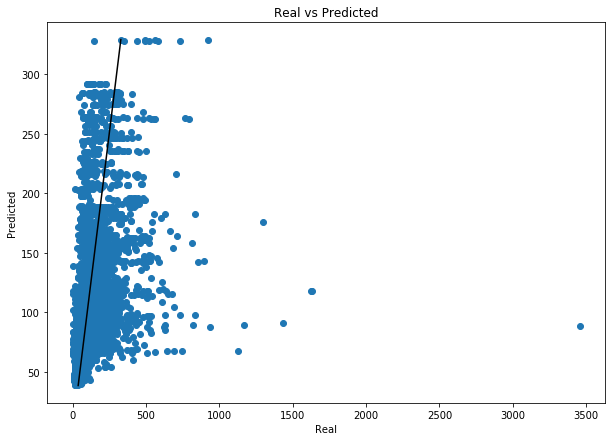

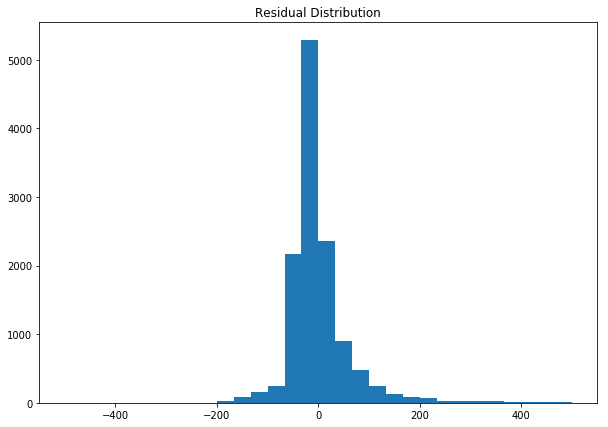

count    12412.000000
mean        41.031279
std         67.681004
min          0.000252
25%         13.382404
50%         26.312921
75%         44.055861
max       3367.341773
Name: seconds, dtype: float64


In [13]:
# Mismos modelos, quitando outliers del train (definición MUY estricta de outlier)
q99 = y_train.quantile(0.99)
upper = q99 + 2*y_train.std()

idx = y_train <= upper

# Linear model
linear = LinearRegression(normalize=True)
linear.fit(X_train[idx].values, y_train[idx].values)
y_pred = linear.predict(X_test)

result = model_results(y_test, y_pred, hist_kwargs={"range": (-500, 500)})
result["model"] = "linear_trimmed"
results.append(result)


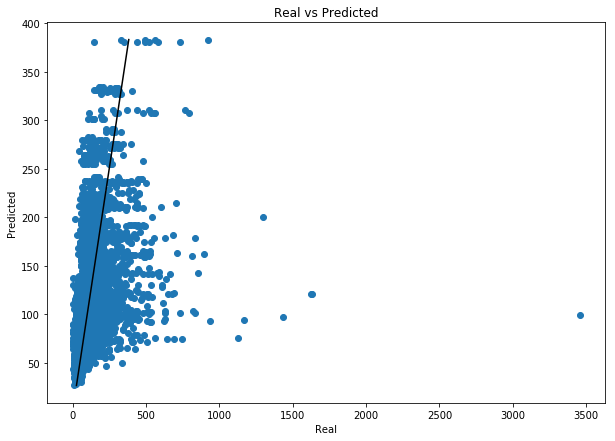

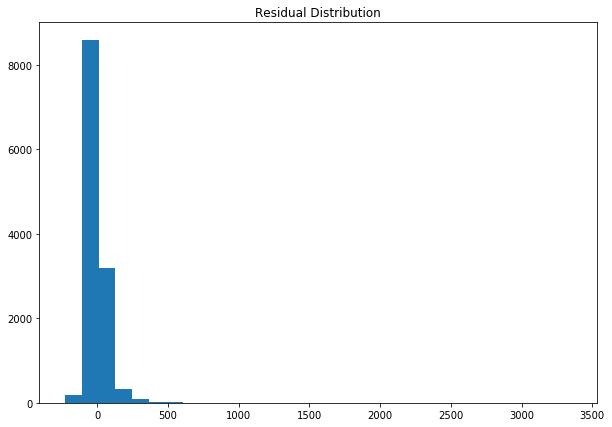

count    12412.000000
mean        40.353675
std         66.595883
min          0.003082
25%         12.870852
50%         25.890564
75%         45.416122
max       3356.474727
Name: seconds, dtype: float64


In [14]:
hle = HourLinearEnsemble(hours=[0,5,9,17,20], normalize=True)
hle.fit(X_train[idx], y_train[idx])
result = model_results(y_test, hle.predict(X_test))
result["model"] = "linear_ensemble_trimmed"
results.append(result)

In [15]:
pd.DataFrame(results)

,mean,median,model,q75,q90,q99,str
0,44.599501,20.083718,google_distance_matrix,46.087958,104.757168,338.917896,79.339095
1,41.766274,27.586482,linear_full,46.171148,85.452222,280.224892,67.164612
2,41.144738,27.016620,linear_ensemble,48.152710,81.118511,269.588681,65.989602
3,41.031279,26.312921,linear_trimmed,44.055861,86.039083,284.884331,67.681004
4,40.353675,25.890564,linear_ensemble_trimmed,45.416122,81.427451,273.273597,66.595883


In [16]:
# save linear ensemble model

import joblib
joblib.dump(hle, "models/linear_ensemble.pkl")

['models/linear_ensemble.pkl']

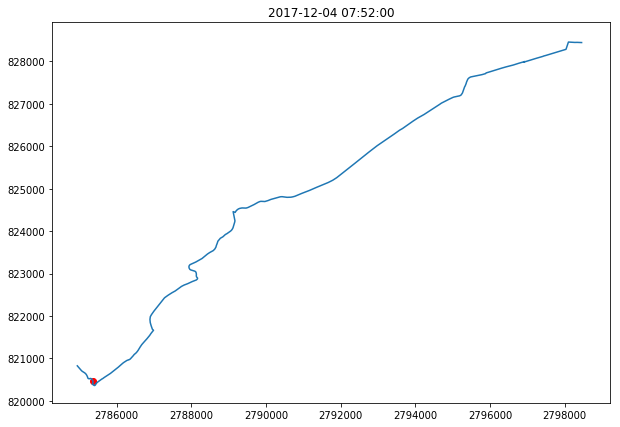

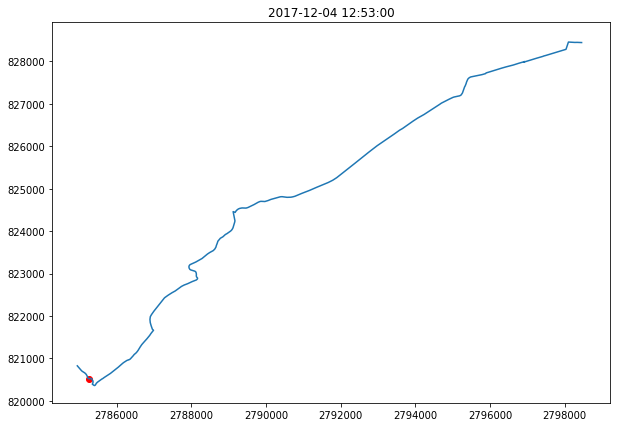

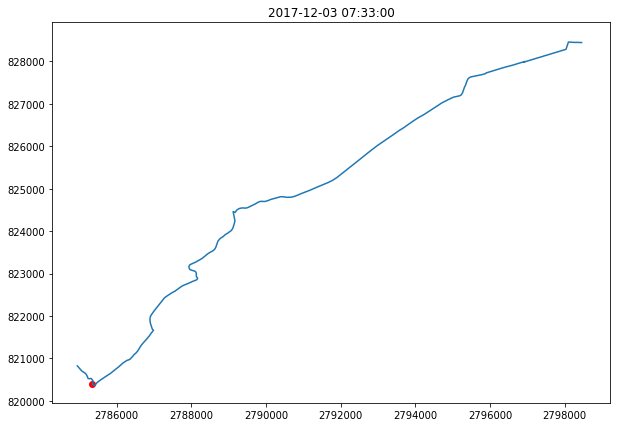

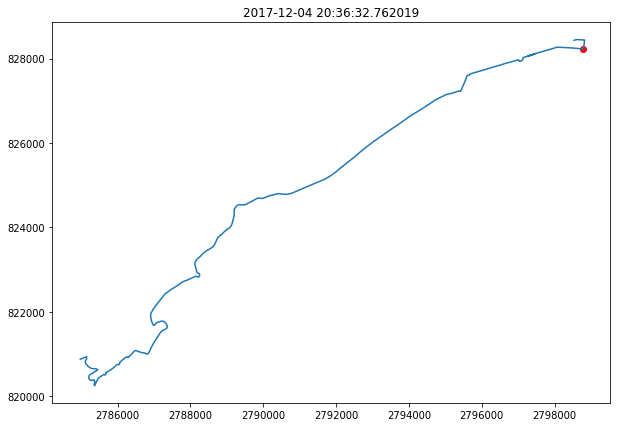

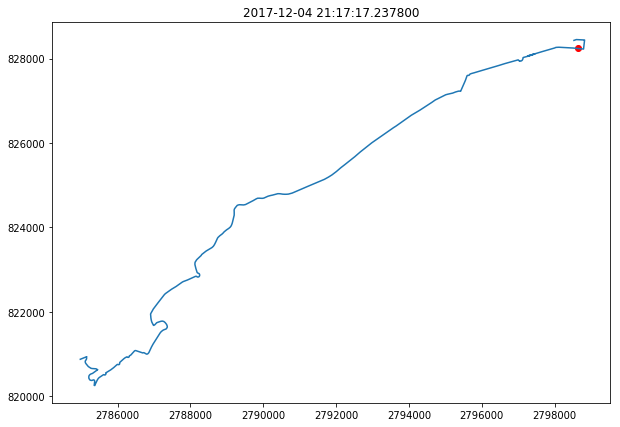

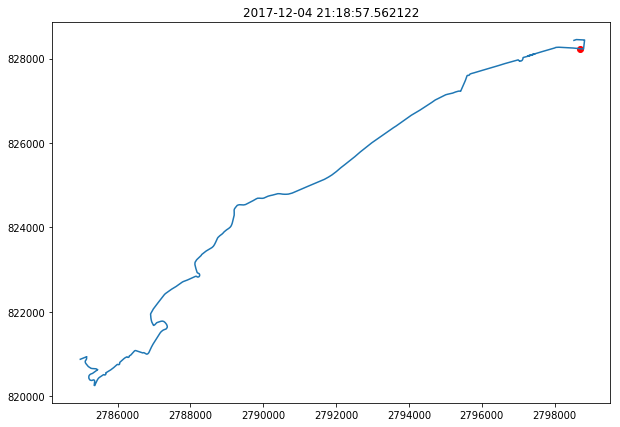

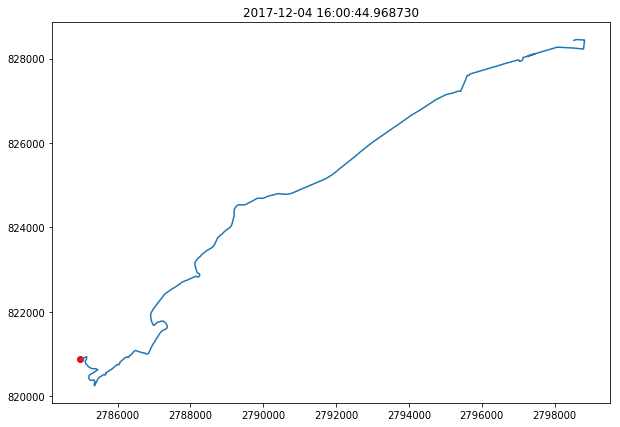

In [18]:
# This cell adds a method to animate the model results

import datetime
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiPoint
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


paradas["travel_distance"] = paradas.distance.shift(-1) - paradas.distance
nr = gdm.join(paradas, on="origin")[["origin", "travel_distance", "duration_in_traffic", "weekend", "hour"]]
r = nr.copy()
nr["raining"] = False
r["raining"] = True

full_combo = pd.concat([nr, r])[["origin", "travel_distance", "duration_in_traffic", "weekend", "hour", "raining"]].dropna()
full_combo["pred"] = hle.predict(full_combo[["travel_distance", "duration_in_traffic", "weekend", "hour", "raining"]])
pred_dict = full_combo.set_index(["origin", "weekend", "hour", "raining"])["pred"]
pred_dict = full_combo.set_index(["origin", "weekend", "hour", "raining"])["pred"]


def points_from_schedule(schedule, line):
    full_idx = pd.Series(None, index=pd.DatetimeIndex(start=schedule.time.min(), end=schedule.time.max(), freq="1 Min"))
    dist_time = pd.concat([full_idx, schedule.distance]).sort_index()
    dist_time = dist_time.interpolate(method="index").dropna()
    points = dist_time.map(lambda d: line.interpolate(d))
    x = points.map(lambda p: p.x)
    x.name = "x"
    y = points.map(lambda p: p.y)
    y.name = "y"
    return pd.concat([x, y], axis=1).asfreq("1 Min")


def sim_animation(w, h, r, leg, line, file):
    if not w:
        start = datetime.datetime(year=2017, month=12, day=4, hour=h, minute=0)
    else:
        start = datetime.datetime(year=2017, month=12, day=3, hour=h, minute=0)
    

    dd = []
    iter_stops = full_combo.origin.unique()
    for s in iter_stops:
        h = start.hour
        w = start.weekday() > 4
        p = pred_dict[(s, w, h, r)]
        dd.append({"origin": s, "weekend": w, "hour": h, "raining": r, "pred": p, "time": start})
        start += pd.Timedelta(value=p, unit="s")
    sched = pd.DataFrame(dd).join(paradas[["distance", "leg", "travel_distance"]], on="origin")
    sched["next"] = sched["distance"] + sched["travel_distance"]
    sched.index = sched.time

    pp = points_from_schedule(sched[sched.leg==leg], line)

    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(10)
    ax.plot(*line.xy)

    point = ax.scatter(pp.iloc[0].x, pp.iloc[0].y, color="red", animated=True)
    def animate(i):
        point.set_offsets(pp.iloc[i][["x", "y"]])
        ax.set_title(pp.index[i])
        return point, ax

    anim = FuncAnimation(fig, animate, frames=np.arange(0, len(pp)), interval=200)
    anim.save(file)
    #HTML(anim.to_html5_video()) # (Still can't figure this out)
    return anim
    


sim_animation(False, 7, False, "outbound", route["outbound"], "resources/bald_7am.mp4")
sim_animation(False, 12, False, "outbound", route["outbound"], "resources/bald_12am.mp4")
sim_animation(True, 7, False, "outbound", route["outbound"], "resources/bald_7am_w.mp4")
sim_animation(False, 18, False, "inbound", route["inbound"], "resources/sf_6pm.mp4")
sim_animation(False, 19, False, "inbound", route["inbound"], "resources/sf_7pm.mp4")
sim_animation(False, 19, True, "inbound", route["inbound"], "resources/sf_7pm_r.mp4")
sim_animation(False, 15, False, "inbound", route["inbound"], "resources/sf_3pm.mp4")